# <div style="text-align: center"> Final Project </div>
<div style="text-align: center"> EE367
<br>
<br>
<div style="text-align: center"> Stanford University Winter 2021 </div>
<br>
<div style="text-align: center"> Erick Blankenberg, Scott Blankenberg </div>

---
_Note: Run all of these cells in order if using for the first time. Make sure that your kernel is set to the environment created with `stereoEnviron.yml`._

---
Imports relevant assets to run all of the algorithms.

1). A Fuzzy Logic Approach for Real Time Processing

2). DeepPruner

In [ ]:
from Utils.google_drive_downloader import GoogleDriveDownloader as gdd
import os, ssl, urllib, shutil, zipfile
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

# NOTE:
#    You need to use the modified version of the repository included in this repository. If 
#    you want to use the original DeepPruner you will need to modify the config scripts and 
#    references to CUDA devices in files in the "models" directory to run on a CPU only machine.

# Retrieve trained model
if not os.path.isfile("Algorithms/DeepPruner/DeepPruner-best-kitti.tar"):
    print("Starting trained model download...")
    gdd.download_file_from_google_drive(file_id='1mSendpKq0vdQMr5XVp5zAHm37dwEgcun', dest_path='./Algorithms/DeepPruner/DeepPruner-best-kitti.tar')
    print("Finshed downloading trained model.")
else:
    print("Trained model already in directory.")

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import imageio
from PIL import Image
from skimage.transform import rescale
from skimage.color import rgb2gray


import os, sys, random
import torch, skimage.io, numpy as np
from Utils import helperfuncs
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..',))
scriptPath = os.path.realpath(os.path.dirname(sys.argv[0]))
currentDir = os.getcwd() # Hack to correct deeppruner imports, TODO MODIFY SOURCE FILES SINCE WE ARENT DOWNLOADING FROM SCRATCH ANYMORE
os.chdir(currentDir +  '/Algorithms/DeepPruner')
from dataloader import preprocess
from models.deeppruner import DeepPruner
from models.config import config as config_args
os.chdir(currentDir)

3). XXXX

In [ ]:
#init code

4). Test images

In [4]:
import os

# Feel free to add more files, if you run this twice existing files will not be re-loaded so just append and load-away!

imageMaxDims = [540, 960] # rows, columns. Some algorithms crash when running on high resolution data. Images and disparities are resized so that no dimension exceeds these values

# List of all sources, each one corresponds to a directory in "Data" which contains Left.jpg, Right.jpg, calib.txt, gTruth.jpg
# Actually importing these is in each of the next cells, if the subfolder does not exist then the image is skipped during evaluation

testImages = list()
root = os.getcwd() + "/Data"
if not os.path.isdir(root):
    print("No Data folder found, creating empty folder...")
    os.mkdir(root)
else:
    for files in os.listdir(root):    
        if os.path.isdir(os.path.join(root,files)):
            testImages.append(files)
    print("Existing Images: ")
    print(testImages)


Existing Images: 
['MBD_2014Scenes_Adirondack-perfect', 'MBD_2014Scenes_Backpack-perfect', 'MBD_2014Scenes_Bicycle1-perfect']


In [5]:
# Middlebury Stereo Evaluation 2014 Images (Full Resolution)

import os, ssl, urllib
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

# takes 6 mins per image set, uncomment this for final load mbd32014Images = ["Adirondack-imperfect", "Backpack-imperfect", "Bicycle1-imperfect", "Cable-imperfect", "Classroom1-imperfect", "Couch-imperfect", "Flowers-imperfect", "Jadeplant-imperfect", "Mask-imperfect", "Motorcycle-imperfect", "Piano-imperfect", "Pipes-imperfect", "Playroom-imperfect", "Playtable-imperfect", "Recycle-imperfect", "Shelves-imperfect", "Shelves-imperfect", "Shopvac-imperfect", "Sticks-imperfect", "Storage-imperfect", "Sword1-imperfect", "Sword2-imperfect", "Umbrella-imperfect", "Vintage-imperfect"]
mbd32014Images = ["Adirondack-perfect", "Backpack-perfect", "Bicycle1-perfect", "Cable-perfect"]

for currentImageName in mbd32014Images:
    imageFolderName = 'MBD_2014Scenes_%s' % (currentImageName)
    if not os.path.isdir('Data/%s' % imageFolderName):
        os.mkdir('Data/%s' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/im0.png" % currentImageName, 'Data/%s/Left.png' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/im1.png" % currentImageName, 'Data/%s/Right.png' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/calib.txt" % currentImageName, 'Data/%s/calib.txt' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/disp0.pfm" % currentImageName, 'Data/%s/disparityGTLeft.pfm' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/disp1.pfm" % currentImageName, 'Data/%s/disparityGTRight.pfm' % imageFolderName)
        testImages.append(imageFolderName)
        print("Loaded: %s" % currentImageName)
    else:
        print("Already Exists: %s" % currentImageName)
        
print("Done Loading!")

Already Exists: Adirondack-perfect
Already Exists: Backpack-perfect
Already Exists: Bicycle1-perfect
Loaded: Cable-perfect
Done Loading!


In [6]:
import os, ssl, urllib
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

# takes 6 mins per image set, uncomment this for final load mbd32014Images = ["Adirondack-imperfect", "Backpack-imperfect", "Bicycle1-imperfect", "Cable-imperfect", "Classroom1-imperfect", "Couch-imperfect", "Flowers-imperfect", "Jadeplant-imperfect", "Mask-imperfect", "Motorcycle-imperfect", "Piano-imperfect", "Pipes-imperfect", "Playroom-imperfect", "Playtable-imperfect", "Recycle-imperfect", "Shelves-imperfect", "Shelves-imperfect", "Shopvac-imperfect", "Sticks-imperfect", "Storage-imperfect", "Sword1-imperfect", "Sword2-imperfect", "Umbrella-imperfect", "Vintage-imperfect"]
mbd2001Images = ["sawtooth", "venus", "bull", "poster", "barn1", "barn2"]

folder_name = 'MBD2_2001Scenes_%s'

for currentImageName in mbd2001Images:
    imageFolderName = folder_name % (currentImageName)
    if not os.path.isdir('Data/%s' % imageFolderName):
        os.mkdir('Data/%s' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2001/data/%s/im0.ppm" % currentImageName, 'Data/%s/Left.ppm' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2001/data/%s/im1.ppm" % currentImageName, 'Data/%s/Right.ppm' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2001/data/%s/disp2.pgm" % currentImageName, 'Data/%s/disparityGTLeft.pgm' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2001/data/%s/disp6.pgm" % currentImageName, 'Data/%s/disparityGTRight.pgm' % imageFolderName)
        testImages.append(imageFolderName)
        print("Loaded: %s" % currentImageName)
    else:
        print("Already Exists: %s" % currentImageName)
        
print("Done Loading!")


mbd2001Images = ["map"]
for currentImageName in mbd2001Images:
    imageFolderName = folder_name % (currentImageName)
    if not os.path.isdir('Data/%s' % imageFolderName):
        os.mkdir('Data/%s' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2001/data/%s/im0.pgm" % currentImageName, 'Data/%s/Left.pgm' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2001/data/%s/im1.pgm" % currentImageName, 'Data/%s/Right.pgm' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2001/data/%s/disp0.pgm" % currentImageName, 'Data/%s/disparityGTLeft.pgm' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2001/data/%s/disp1.pgm" % currentImageName, 'Data/%s/disparityGTRight.pgm' % imageFolderName)
        testImages.append(imageFolderName)
        print("Loaded: %s" % currentImageName)
    else:
        print("Already Exists: %s" % currentImageName)
        
print("Done Loading!")

mbd2001Images = ["tsukuba"]
for currentImageName in mbd2001Images:
    imageFolderName = folder_name % (currentImageName)
    if not os.path.isdir('Data/%s' % imageFolderName):
        os.mkdir('Data/%s' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2001/data/%s/scene1.row3.col1.ppm" % currentImageName, 'Data/%s/Left.ppm' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2001/data/%s/scene1.row3.col2.ppm" % currentImageName, 'Data/%s/Right.ppm' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2001/data/%s/truedisp.row3.col3.pgm" % currentImageName, 'Data/%s/disparityGTLeft.pgm' % imageFolderName)
        testImages.append(imageFolderName)
        print("Loaded: %s" % currentImageName)
    else:
        print("Already Exists: %s" % currentImageName)
        
print("Done Loading!")



Loaded: sawtooth
Loaded: venus
Loaded: bull
Loaded: poster
Loaded: barn1
Loaded: barn2
Done Loading!
Loaded: map
Done Loading!
Loaded: tsukuba
Done Loading!


In [ ]:
# Middlebury Stereo Evaluation 2006 Half Resolution Images
"""
import os, ssl, urllib
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

# takes 6 mins per image set, uncomment this for final load mbd32014Images = ["Adirondack-imperfect", "Backpack-imperfect", "Bicycle1-imperfect", "Cable-imperfect", "Classroom1-imperfect", "Couch-imperfect", "Flowers-imperfect", "Jadeplant-imperfect", "Mask-imperfect", "Motorcycle-imperfect", "Piano-imperfect", "Pipes-imperfect", "Playroom-imperfect", "Playtable-imperfect", "Recycle-imperfect", "Shelves-imperfect", "Shelves-imperfect", "Shopvac-imperfect", "Sticks-imperfect", "Storage-imperfect", "Sword1-imperfect", "Sword2-imperfect", "Umbrella-imperfect", "Vintage-imperfect"]
mbd2006HalfImages = ["", "", "", "", ""]

for currentImageName in mbd32014Images:
    imageFolderName = 'MBD_2014Scenes_%s' % (currentImageName)
    if not os.path.isdir('Data/%s' % imageFolderName):
        os.mkdir('Data/%s' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/im0.png" % currentImageName, 'Data/%s/Left.png' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/im1.png" % currentImageName, 'Data/%s/Right.png' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/calib.txt" % currentImageName, 'Data/%s/calib.txt' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/disp0.pfm" % currentImageName, 'Data/%s/disparityGTLeft.pfm' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/disp1.pfm" % currentImageName, 'Data/%s/disparityGTRight.pfm' % imageFolderName)
        testImages.append(imageFolderName)
        print("Loaded: %s" % currentImageName)
    else:
        print("Already Exists: %s" % currentImageName)

"""

---
Runs each of the algorithms

In [ ]:
# Fuzzy Logic


In [ ]:
# Deeppruner

import os, sys, random
import torch, skimage.io, numpy as np
from Utils import helperfuncs
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..',))
scriptPath = os.path.realpath(os.path.dirname(sys.argv[0]))
currentDir = os.getcwd() # Hack to correct deeppruner imports, TODO MODIFY SOURCE FILES SINCE WE ARENT DOWNLOADING FROM SCRATCH ANYMORE
os.chdir(currentDir +  '/Algorithms/DeepPruner')
from dataloader import preprocess
from models.deeppruner import DeepPruner
from models.config import config as config_args
os.chdir(currentDir)

torch.backends.cudnn.benchmark = True
doUseCuda = torch.cuda.is_available()
costAggregatorScale = config_args.cost_aggregator_scale
downsampleScale     = costAggregatorScale * 8.0

if doUseCuda:
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    random.seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True

model = DeepPruner()
model = torch.nn.DataParallel(model)
if doUseCuda:
    model.cuda()

print('Number of model parameters: {}'.format(sum([p.data.nelement() for p in model.parameters()])))

print("Loading model...")
state_dict = torch.load("./Algorithms/DeepPruner/DeepPruner-best-kitti.tar", map_location=torch.device('cpu'))
model.load_state_dict(state_dict['state_dict'], strict=True)

print("Model loaded. Running evaluations...")

def runtestDeepPruner(imageLeft, imageRight):
    processed = preprocess.get_transform()
    imgL = processed(imageLeft).numpy()
    imgR = processed(imageRight).numpy()

    imgL = np.reshape(imgL, [1, 3, imgL.shape[1], imgL.shape[2]])
    imgR = np.reshape(imgR, [1, 3, imgR.shape[1], imgR.shape[2]])

    w = imgL.shape[3]
    h = imgL.shape[2]
    dw = int(downsampleScale - (w%downsampleScale + (w%downsampleScale==0)*downsampleScale))
    dh = int(downsampleScale - (h%downsampleScale + (h%downsampleScale==0)*downsampleScale))

    top_pad = dh
    left_pad = dw
    imgL = np.lib.pad(imgL, ((0, 0), (0, 0), (top_pad, 0), (0, left_pad)), mode='constant', constant_values=0)
    imgR = np.lib.pad(imgR, ((0, 0), (0, 0), (top_pad, 0), (0, left_pad)), mode='constant', constant_values=0)

    model.eval()
    disparity = None
    with torch.no_grad():
        imgLVar = torch.autograd.Variable(torch.FloatTensor(imgL))
        imgRVar = torch.autograd.Variable(torch.FloatTensor(imgR))

        if doUseCuda:
            imgLVar, imgRVar = imgLVar.cuda(), imgRVar.cuda()

        disparity = model(imgLVar, imgRVar)
    
    disparity = disparity[0, top_pad:, :-left_pad].data.cpu().numpy()
    
    return disparity



for currentImage in testImages:
    outPath   = "Output/%s/DeepPruner" % currentImage
    if not os.path.isdir(outPath):
        if not os.path.isdir("Output"):
            print("No Output folder, creating empty folder.")
            os.mkdir("Output")
        if not os.path.isdir("Output/%s" % currentImage):
            os.mkdir("Output/%s" % currentImage)
        os.mkdir(outPath)
    elif os.path.isfile(outPath + "/OutDisparity.png"):
        print("Disparity for image %s alreay exists, skipping." % (currentImage))
        continue
        
    leftPath  = "Data/%s/Left.png" % currentImage
    rightPath = "Data/%s/Right.png" % currentImage
    
    # Loads the data
    imgL = skimage.io.imread(leftPath)
    imgR = skimage.io.imread(rightPath)
    
    # > Resize 
    imgL = helperfuncs.standardizedResize(imgL, imageMaxDims)
    imgR = helperfuncs.standardizedResize(imgR, imageMaxDims)
    # > TODO CAMERA CALIBRATION
    
    # Does the work
    disparity = runtestDeepPruner(imgL, imgR)
    
    skimage.io.imsave(outPath + "/OutDisparity.png", (disparity * 256).astype('uint16'))
    print("Finished disparity for image %s." % (currentImage))


In [ ]:
# XXX


MBD_2014Scenes_Adirondack-perfect False


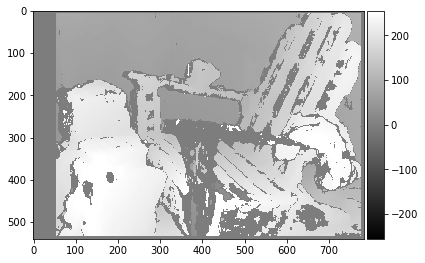

Finished disparity for image MBD_2014Scenes_Adirondack-perfect.
MBD_2014Scenes_Backpack-perfect False


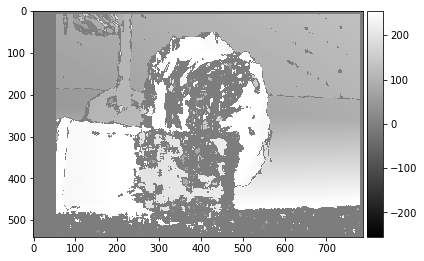

Finished disparity for image MBD_2014Scenes_Backpack-perfect.
MBD_2014Scenes_Bicycle1-perfect False


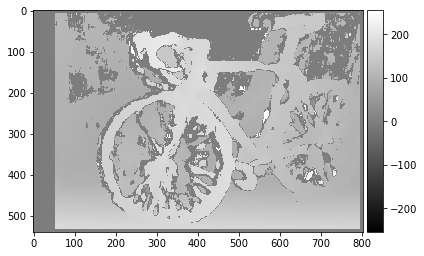

Finished disparity for image MBD_2014Scenes_Bicycle1-perfect.
MBD_2014Scenes_Cable-perfect False


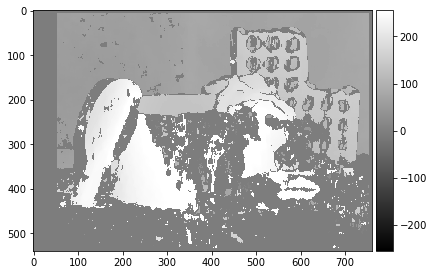

Finished disparity for image MBD_2014Scenes_Cable-perfect.
MBD2_2001Scenes_sawtooth True


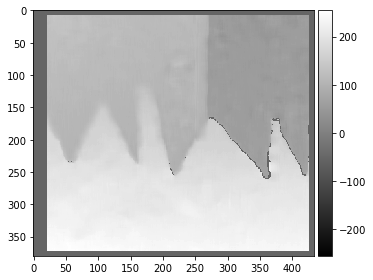

Finished disparity for image MBD2_2001Scenes_sawtooth.
MBD2_2001Scenes_venus True


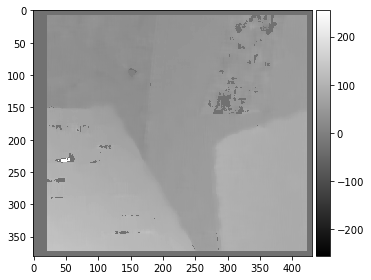

Finished disparity for image MBD2_2001Scenes_venus.
MBD2_2001Scenes_bull True


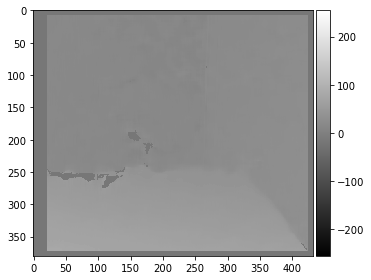

Finished disparity for image MBD2_2001Scenes_bull.
MBD2_2001Scenes_poster True


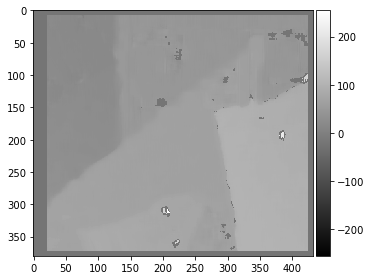

Finished disparity for image MBD2_2001Scenes_poster.
MBD2_2001Scenes_barn1 True


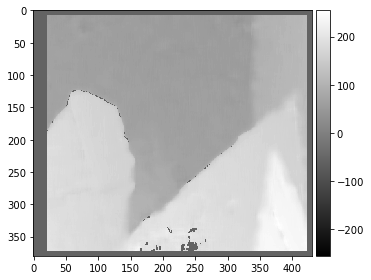

Finished disparity for image MBD2_2001Scenes_barn1.
MBD2_2001Scenes_barn2 True


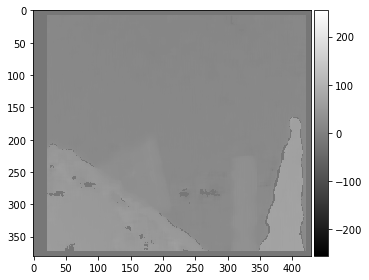

Finished disparity for image MBD2_2001Scenes_barn2.
MBD2_2001Scenes_map False


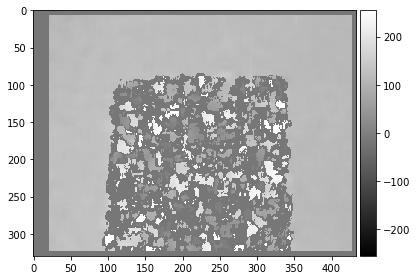

Finished disparity for image MBD2_2001Scenes_map.
MBD2_2001Scenes_tsukuba False


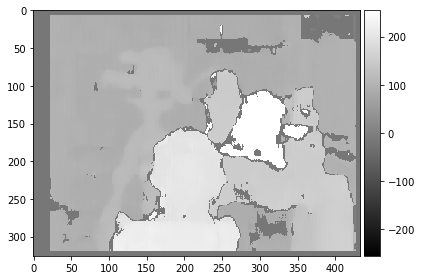

Finished disparity for image MBD2_2001Scenes_tsukuba.


In [12]:

def standardizedResizeBM(highResImage, maximumDimensions):
    imageSize = highResImage.shape
    imageRowsRescale =  maximumDimensions[0] / imageSize[0]
    imageColsRescale = maximumDimensions[1] / imageSize[1]
    scaleFactor = min(imageRowsRescale, imageColsRescale)
    out0 = rescale(highResImage[:, :], scaleFactor)
    return out0

def runtestStereoBM(imageLeft, imageRight, params):
    stereo = cv.StereoBM_create(numDisparities=params[0], blockSize=params[1])
    disp2 = stereo.compute(imgL,imgR)
    norm_coeff = 255 / disp2.max()
    disparity = norm_coeff*disp2
    #plt.imshow(disparity, "gray")
    skimage.io.imshow(disparity, cmap=plt.cm.gray)
    plt.show()
    return disparity

images_2001_group1 = ["MBD2_2001Scenes_sawtooth", "MBD2_2001Scenes_venus", "MBD2_2001Scenes_bull", "MBD2_2001Scenes_poster", "MBD2_2001Scenes_barn1", "MBD2_2001Scenes_barn2"]
images_2001_group2= ["MBD2_2001Scenes_map"]
images_2001_group3 = ["MBD2_2001Scenes_tsukuba"]
curr_dim = imageMaxDims
for currentImage in testImages:
    outPath   = "Output/%s/StereoBM2" % currentImage
    if not os.path.isdir(outPath):
        if not os.path.isdir("Output"):
            print("No Output folder, creating empty folder.")
            os.mkdir("Output")
        if not os.path.isdir("Output/%s" % currentImage):
            os.mkdir("Output/%s" % currentImage)
        os.mkdir(outPath)
    elif os.path.isfile(outPath + "/OutDisparity.png"):
        print("Disparity for image %s alreay exists, skipping." % (currentImage))
        continue
        
        
    print(currentImage, currentImage in images_2001_group1)
    if currentImage in images_2001_group1:
        leftPath  = "Data/%s/Left.ppm" % currentImage
        rightPath = "Data/%s/Right.ppm" % currentImage
        curr_dim = [380, 434]
        params = [16, 15]
    elif currentImage in images_2001_group2:
        leftPath  = "Data/%s/Left.pgm" % currentImage
        rightPath = "Data/%s/Right.pgm" % currentImage
        params = [16, 15]
        curr_dim = [380, 434]
    elif currentImage in images_2001_group3:
        leftPath  = "Data/%s/Left.ppm" % currentImage
        rightPath = "Data/%s/Right.ppm" % currentImage
        curr_dim = [380, 434]
        params = [16, 15]
    else:
        leftPath  = "Data/%s/Left.png" % currentImage
        rightPath = "Data/%s/Right.png" % currentImage
        curr_dim = imageMaxDims
        params = [16*3, 15]
    
    
    # Loads the data
    imgL = np.array(Image.open(leftPath).convert('L'))
    imgR = np.array(Image.open(rightPath).convert('L'))
    
    # > Resize 
    
    imgL = 255*np.array(standardizedResizeBM(imgL, curr_dim))
    imgL = imgL.astype(np.uint8)
    
    imgR = 255*np.array(standardizedResizeBM(imgR, curr_dim))
    imgR = imgR.astype(np.uint8)
    # > TODO CAMERA CALIBRATION
    
    # Does the work
    disparity = runtestStereoBM(imgL, imgR, params)
    
    skimage.io.imsave(outPath + "/OutDisparity.png", (disparity).astype('uint8'))
    print("Finished disparity for image %s." % (currentImage))

---
Compares results

In [ ]:
print(testImages)